In [2]:
import sys
sys.path.append("../src/")
from data import train_and_testloader_from_pc, dataloader_from_pc
from model import AEDist
import numpy as np
import torch
import phate
from heatgeo.embedding import HeatGeo
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from scipy.spatial import procrustes
import scanpy as sc
import scprep
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb
import hydra
import os
from omegaconf import DictConfig, OmegaConf
import wandb

In [3]:
adata = sc.read('../data/sea_ad_merfish_used_in_analysis_subset12000.h5ad', backed='r')

/gpfs/gibbs/pi/krishnaswamy_smita/xingzhi/.conda_envs/geosink/lib/python3.11/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [4]:
ckpt_path='../src/wandb/run-20240102_173152-8aghh27z/files/epoch=2-step=28800.ckpt'
model = AEDist.load_from_checkpoint(ckpt_path, dim=adata.shape[1], emb_dim=adata.obsm['X_phate'].shape[1], w=256)

In [5]:
X_tensor = torch.from_numpy(adata[:,:].X.toarray()).float()
xhat, z = model(X_tensor)
xhat = xhat.cpu().detach().numpy()
z = z.cpu().detach().numpy()

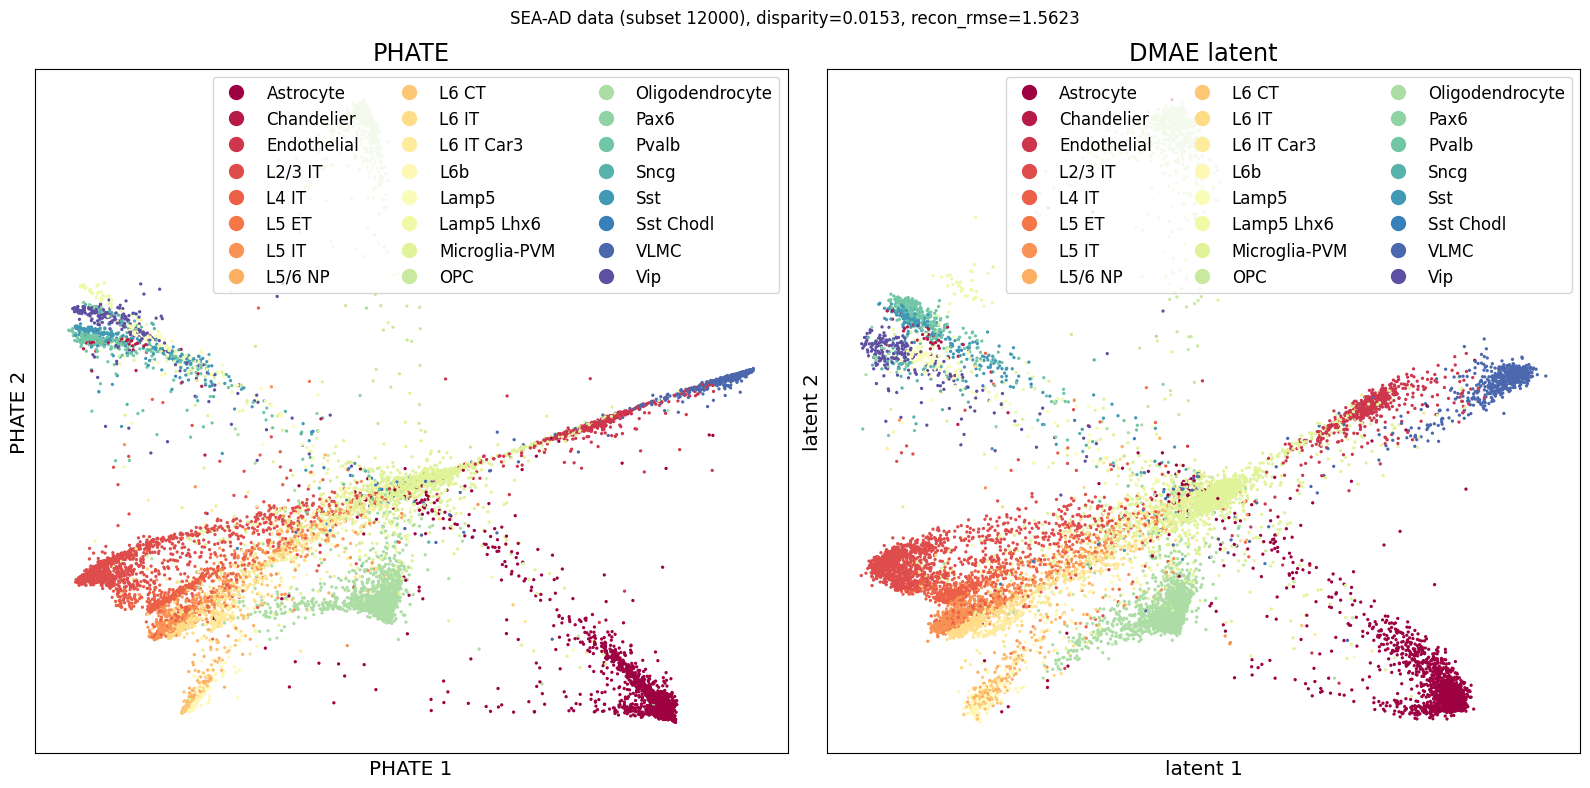

In [7]:
recon_rmse = np.sqrt(np.square(xhat - X_tensor.numpy()).mean())

pc_rot, z_rot, disparity = procrustes(adata.obsm['X_phate'], z)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot the first scatter plot
scprep.plot.scatter2d(adata.obsm['X_phate'], c=adata.obs['Subclass'], ax=axes[0], cmap="Spectral",
                      ticks=False, label_prefix="PHATE ", title='PHATE')

# Plot the second scatter plot
scprep.plot.scatter2d(z_rot, c=adata.obs['Subclass'], ax=axes[1], cmap="Spectral",
                      ticks=False, label_prefix="latent ", title='DMAE latent')
plt.suptitle(f"SEA-AD data (subset 12000), disparity={disparity:.4f}, recon_rmse={recon_rmse:.4f}")
plt.tight_layout()
plt.show()